In [25]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4') # Download Open Multilingual WordNet

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

In [10]:
train=pd.read_csv('train.csv')
test_df=pd.read_csv('test.csv')
label_df=pd.read_csv('test_labels.csv')
sample=pd.read_csv('sample_submission.csv')

In [5]:
train.head(7)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0


In [6]:
test_df.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [7]:
label_df.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [8]:
sample.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.5,0.5,0.5,0.5,0.5,0.5
1,0000247867823ef7,0.5,0.5,0.5,0.5,0.5,0.5
2,00013b17ad220c46,0.5,0.5,0.5,0.5,0.5,0.5
3,00017563c3f7919a,0.5,0.5,0.5,0.5,0.5,0.5
4,00017695ad8997eb,0.5,0.5,0.5,0.5,0.5,0.5


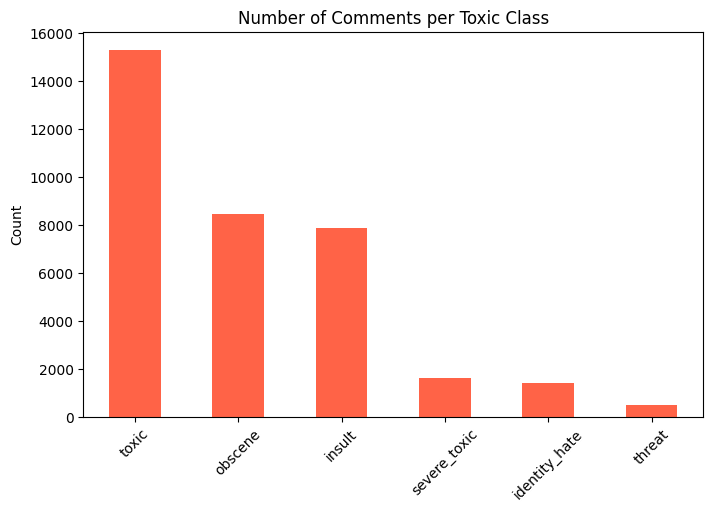

In [11]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

train[label_cols].sum().sort_values(ascending=False).plot(kind='bar', figsize=(8,5), color='tomato')
plt.title("Number of Comments per Toxic Class")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

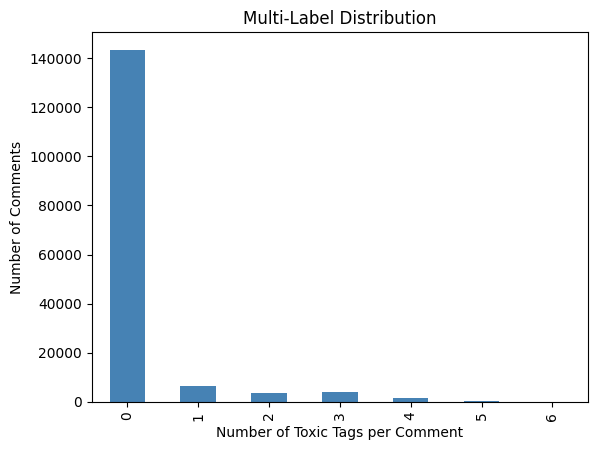

In [12]:
train['label_sum'] = train[label_cols].sum(axis=1)

train['label_sum'].value_counts().sort_index().plot(kind='bar', color='steelblue')
plt.title("Multi-Label Distribution")
plt.xlabel("Number of Toxic Tags per Comment")
plt.ylabel("Number of Comments")
plt.show()

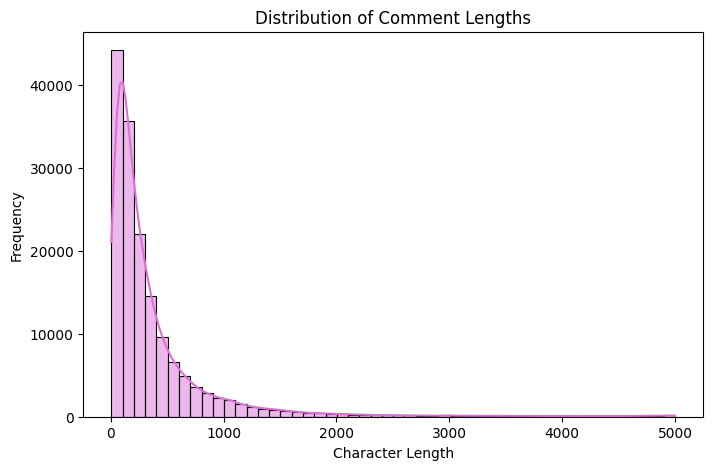

In [13]:
train['comment_length'] = train['comment_text'].str.len()

plt.figure(figsize=(8,5))
sns.histplot(train['comment_length'], bins=50, kde=True, color='orchid')
plt.title("Distribution of Comment Lengths")
plt.xlabel("Character Length")
plt.ylabel("Frequency")
plt.show()

In [19]:
for label in label_cols:
    print(f"\n\nExample of '{label.upper()}':\n")
    example = train[train[label] == 1]['comment_text'].iloc[3]
    print(example)




Example of 'TOXIC':

You are gay or antisemmitian? 

Archangel WHite Tiger

Meow! Greetingshhh!

Uh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...

1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!

2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals!

3 - First and last warning, you fucking gay - I won't appreciate if any more nazi shwain would write in my page! I don't wish to talk to you anymore!

Beware of the Dark Side!


Example of 'SEVERE_TOXIC':

Hi 

Im a fucking bitch.

50.180.208.181


Example of 'OBSCENE':

GET FUCKED UP. GET FUCKEEED UP.  GOT A DRINK THAT YOU CANT PUT DOWN???/ GET FUCK UP GET FUCKED UP.  I'M FUCKED UP RIGHT NOW!


Example of 'THREAT':

Fuck you, Smith. Please have me notified when you die. I want to dance on your grav

In [22]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [28]:
train['clean_text'] = train['comment_text'].apply(clean_text)
test_df['clean_text'] = test_df['comment_text'].apply(clean_text)

In [29]:
tfidf = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1,2),
    stop_words='english'
)

In [31]:
X_train = tfidf.fit_transform(train['clean_text'])
X_test = tfidf.transform(test_df['clean_text'])

print("TF-IDF matrix shape (train):", X_train.shape)
print("TF-IDF matrix shape (test):", X_test.shape)

TF-IDF matrix shape (train): (159571, 50000)
TF-IDF matrix shape (test): (153164, 50000)


In [32]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y_train = train[label_cols]

In [33]:
model = OneVsRestClassifier(LogisticRegression(solver='liblinear'))
model.fit(X_train, y_train)

OneVsRestClassifier(estimator=LogisticRegression(solver='liblinear'))

In [34]:
train_preds = model.predict_proba(X_train)

for i, label in enumerate(label_cols):
    score = roc_auc_score(y_train[label], train_preds[:, i])
    print(f"{label}: ROC AUC = {score:.4f}")

mean_auc = roc_auc_score(y_train, train_preds, average='macro')
print(f"\nMean ROC AUC: {mean_auc:.4f}")

toxic: ROC AUC = 0.9841
severe_toxic: ROC AUC = 0.9917
obscene: ROC AUC = 0.9914
threat: ROC AUC = 0.9952
insult: ROC AUC = 0.9873
identity_hate: ROC AUC = 0.9895

Mean ROC AUC: 0.9899


In [37]:
test_preds = model.predict_proba(X_test)

In [43]:
custom_text = input("enter a comment :--   ")


custom_text_transformed = tfidf.transform([custom_text])


prediction = model.predict(custom_text_transformed)


print("Predicted toxic probabilities (multi-label):")
for label, score in zip(label_cols, prediction[0]):
    print(f"{label}: {score:.2f}")

enter a comment :--   i will kill you
Predicted toxic probabilities (multi-label):
toxic: 1.00
severe_toxic: 0.00
obscene: 0.00
threat: 1.00
insult: 0.00
identity_hate: 0.00
